In [75]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

As we passed the NHL season's first quarter mark, I propose an evaluation of every team, using a staple of sports analytics: the Pythagorean Expectation. The formula, orignally outlined by baseball analyst, relates runs scored and conceded by a team with its win percentage. I start by adapting the formula to NHL scores using the mean absolute error criterion, and use it to evaluate how teams performed against expectations.

In [76]:
conn = psycopg2.connect("dbname=nhl_db")
cur = conn.cursor()

In [77]:
cur.execute("""
    SELECT
        team,
        season,
        game_date,
        win,
        loss,
        ot_loss,
        goals_for,
        goals_against
    FROM summary
    WHERE playoffs = FALSE
    AND season >= '2012/13'
""")

In [78]:
df = pd.DataFrame(data=cur.fetchall(), columns=["team", "season", "date", "wins", "losses", "ot_losses", "goals_for", "goals_against"])

In [79]:
conn.close()

In [80]:
df.losses = df.losses + df.ot_losses
df.drop("ot_losses", axis=1, inplace=True)
df["games_played"] = 1

In [81]:
season_df = df.groupby(["team", "season"], as_index=False).sum(numeric_only=True)

In [82]:
new_season_df = season_df.loc[season_df.season == "2022/23", :]
season_df = season_df.loc[season_df.season != "2022/23", :]

In [83]:
def pythagoreanExpectation(row, alpha=2):
    return row.games_played * pow(row.goals_for,alpha) / (pow(row.goals_for,alpha) + pow(row.goals_against,alpha))

In [84]:
def optimizePythagoreanExpectation(group, column_name):
    def f(alpha):
        pyth_exp = group.apply(lambda x: pythagoreanExpectation(x, alpha=alpha), axis=1)
    
        mse = mean_absolute_error(group["wins"], pyth_exp)

        return mse
    
    res = minimize(f, x0=2.0)
    group[column_name] = res.x[0]
    group[f"{column_name}_mae"] = res.fun

    return group

In [85]:
cut_offs = ["2012/13", "2015/16", "2020/21", "2021/22"]

In [92]:
for season in cut_offs:
    alpha_df = optimizePythagoreanExpectation(
        season_df.loc[season_df.season >= season, ["season", "team", "wins", "goals_for", "goals_against", "games_played"]],
        f"alpha_{season}")
    alpha_df[["team", "season", f"alpha_{season}", f"alpha_{season}_mae"]]
    
    season_df = season_df.merge(alpha_df, how="left")
    season_df[f"{season}_pyth_exp"] = pow(season_df["goals_for"], season_df[f"alpha_{season}"]) / (pow(season_df["goals_for"], season_df[f"alpha_{season}"]) + pow(season_df["goals_against"], season_df[f"alpha_{season}"]))
    season_df[f"{season}_expected_wins"] = season_df[f"{season}_pyth_exp"] * season_df["games_played"]
    season_df[f"{season}_error"] = abs(season_df[f"{season}_expected_wins"] - season_df[f"wins"])
    season_df[f"{season}_error_pct"] = round(season_df[f"{season}_error"] / season_df["games_played"],4)

In [93]:
season_df.tail(10)

,team,season,wins,losses,goals_for,goals_against,games_played,alpha_2012/13,alpha_2012/13_mae,2012/13_pyth_exp,...,2020/21_pyth_exp,2020/21_expected_wins,2020/21_error,2020/21_error_pct,alpha_2021/22,alpha_2021/22_mae,2021/22_pyth_exp,2021/22_expected_wins,2021/22_error,2021/22_error_pct
296,WSH,2012/13,27,21,146,130,48,2.152426,1.779986,0.562136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,WSH,2013/14,38,44,225,229,82,2.152426,1.779986,0.490519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,WSH,2014/15,45,37,237,199,82,2.152426,1.779986,0.592944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,WSH,2015/16,56,26,248,191,82,2.152426,1.779986,0.636942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,WSH,2016/17,55,27,261,177,82,2.152426,1.779986,0.697609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,WSH,2017/18,49,33,256,238,82,2.152426,1.779986,0.539151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,WSH,2018/19,48,34,274,248,82,2.152426,1.779986,0.553444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,WSH,2019/20,41,28,236,212,69,2.152426,1.779986,0.557455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,WSH,2020/21,36,20,188,161,56,2.152426,1.779986,0.582661,...,0.585779,32.803636,3.196364,0.0571,NaN,NaN,NaN,NaN,NaN,NaN
305,WSH,2021/22,44,38,270,242,82,2.152426,1.779986,0.558643,...,0.560877,45.991909,1.991909,0.0243,2.231023,2.521477,0.560764,45.982619,1.982619,0.0242


In [74]:
season_df.drop(["wins", "losses", "goals_for", "goals_against"], axis=1).groupby(["season"], as_index=False).last()

,season,team,games_played,alpha_2012/13,alpha_2012/13_mae,alpha_2015/16,alpha_2015/16_mae,alpha_2020/21,alpha_2020/21_mae,alpha_2021/22,alpha_2021/22_mae
0,2012/13,WSH,48,2.152426,1.779986,NaN,NaN,NaN,NaN,NaN,NaN
1,2013/14,WSH,82,2.152426,1.779986,NaN,NaN,NaN,NaN,NaN,NaN
2,2014/15,WSH,82,2.152426,1.779986,NaN,NaN,NaN,NaN,NaN,NaN
3,2015/16,WSH,82,2.152426,1.779986,2.208565,1.714759,NaN,NaN,NaN,NaN
4,2016/17,WSH,82,2.152426,1.779986,2.208565,1.714759,NaN,NaN,NaN,NaN
5,2017/18,WSH,82,2.152426,1.779986,2.208565,1.714759,NaN,NaN,NaN,NaN
6,2018/19,WSH,82,2.152426,1.779986,2.208565,1.714759,NaN,NaN,NaN,NaN
7,2019/20,WSH,69,2.152426,1.779986,2.208565,1.714759,NaN,NaN,NaN,NaN
8,2020/21,WSH,56,2.152426,1.779986,2.208565,1.714759,2.235224,2.156752,NaN,NaN
9,2021/22,WSH,82,2.152426,1.779986,2.208565,1.714759,2.235224,2.156752,2.231023,2.521477


In [11]:
season_df = optimizePythagoreanExpectation(season_df, "alpha_1")

In [12]:
season_df = season_df.groupby(["season"], group_keys=True).apply(lambda x: optimizePythagoreanExpectation(x, "alpha_2"))
season_df.reset_index(drop = True, inplace = True)

In [13]:
season_df["exp_win_pct_1"] = pow(season_df.goals_for, season_df.alpha_1) / (pow(season_df.goals_for, season_df.alpha_1) + pow(season_df.goals_against, season_df.alpha_1))
season_df["exp_win_pct_2"] = pow(season_df.goals_for, season_df.alpha_2) / (pow(season_df.goals_for, season_df.alpha_2) + pow(season_df.goals_against, season_df.alpha_2))

In [14]:
season_df["exp_wins_1"] = season_df["exp_win_pct_1"] * season_df["games_played"]
season_df["exp_wins_2"] = season_df["exp_win_pct_2"] * season_df["games_played"]

In [15]:
season_df["error_1"] = abs(season_df['exp_wins_1'] - season_df['wins'])
season_df["error_2"] = abs(season_df['exp_wins_2'] - season_df['wins'])

In [16]:
season_df["error_1_pct"] = round(season_df["error_1"] / season_df["games_played"], 4)
season_df["error_2_pct"] = round(season_df["error_2"] / season_df["games_played"], 4)

In [17]:
season_df.tail()

,team,season,wins,losses,goals_for,goals_against,games_played,alpha_1,alpha_1_mae,alpha_2,alpha_2_mae,exp_win_pct_1,exp_win_pct_2,exp_wins_1,exp_wins_2,error_1,error_2,error_1_pct,error_2_pct
301,TOR,2021/22,54,28,312,252,82,2.152426,1.779986,2.231023,2.521477,0.612944,0.616918,50.261375,50.587309,3.738625,3.412691,0.0456,0.0416
302,VAN,2021/22,40,42,246,231,82,2.152426,1.779986,2.231023,2.521477,0.533803,0.535033,43.771822,43.872710,3.771822,3.872710,0.0460,0.0472
303,VGK,2021/22,43,39,262,244,82,2.152426,1.779986,2.231023,2.521477,0.538226,0.539616,44.134506,44.248493,1.134506,1.248493,0.0138,0.0152
304,WPG,2021/22,39,43,250,253,82,2.152426,1.779986,2.231023,2.521477,0.493582,0.493347,40.473684,40.454467,1.473684,1.454467,0.0180,0.0177
305,WSH,2021/22,44,38,270,242,82,2.152426,1.779986,2.231023,2.521477,0.558643,0.560764,45.808729,45.982619,1.808729,1.982619,0.0221,0.0242


KeyError: 'overall_pe_alpha'

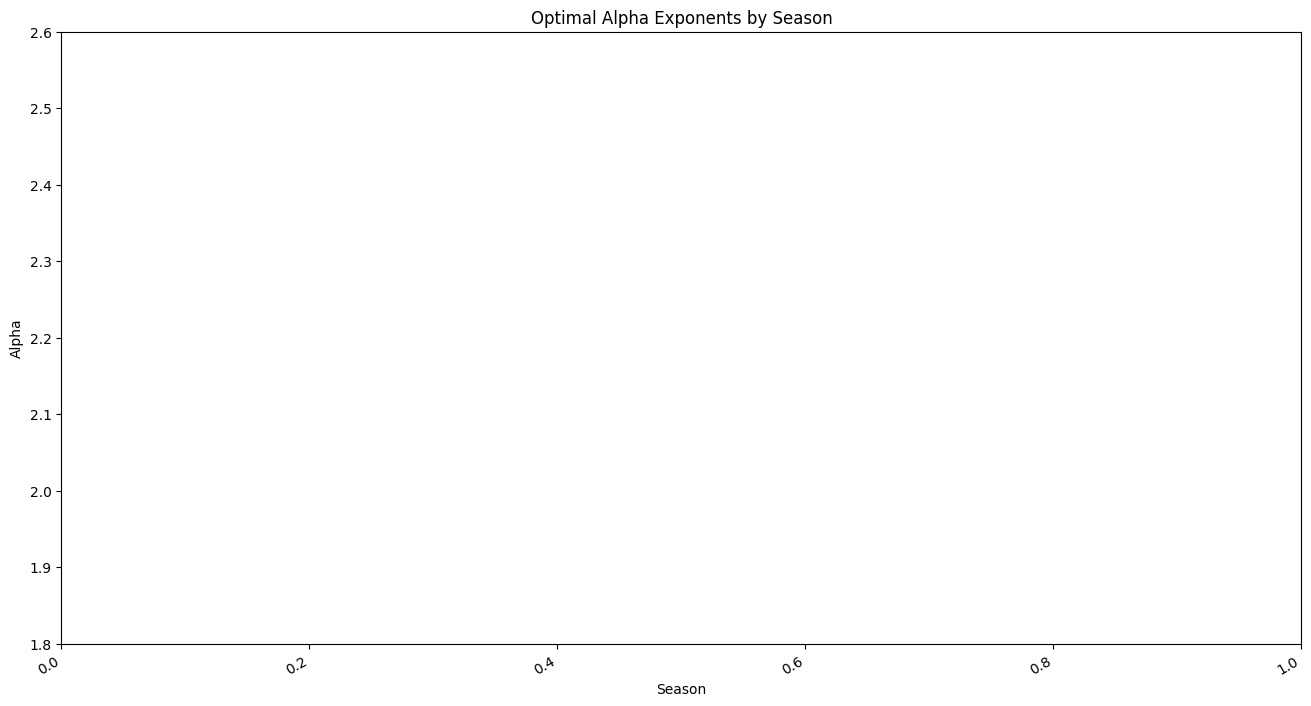

In [18]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Optimal Alpha Exponents by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Alpha")
ax.set_ylim([1.8, 2.6])
fig.autofmt_xdate()

ax.plot(season_df["season"], season_df["overall_pe_alpha"], '-', linewidth=2.0, color="black")
ax.plot(season_df["season"], season_df["league_pe_alpha"], 'o-', linewidth=2.0, color="green")
ax.text(-0,1.015*season_df.league_pe_alpha.mean(),
        f"{round(season_df.overall_pe_alpha.mean(),4)}")


plt.show()

The proposed optimization method yields an alpha value slightly higher than the initial 2.0. Optimization on individual seasons

In [ ]:
df["goal_difference"] = abs(df["goals_for"] - df["goals_against"])
goals_df = df.groupby(["season"]).agg({"goals_for": ["mean", "std"], "goal_difference": ["mean", "std"]}, as_index=False)

In [ ]:
goals_df["goal_difference"]["mean"]

In [ ]:
goals_df["goal_difference"]["std"]

In [ ]:
fig, ax = plt.subplots(1,2)